# Multi-regression of the metabolites concentrations

## Install required python modules

In [ ]:
%%bash
pip install -e ../.

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [1]:
import numpy as np

filename_spectrum = '../data/concentration_data/Spectra_Mixt1.txt'
filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
data_spectrum = np.loadtxt(filename_spectrum, dtype=float)
data_concentrations = np.loadtxt(filename_concentrations, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum.shape[1]+1))

In [3]:
#Convert into dataframes
import pandas as pd

df_spectrum = pd.DataFrame(data_spectrum).T
df_concentrations = pd.DataFrame(data_concentrations).T

In [6]:
print(df_spectrum.shape)
print(df_concentrations.shape)

(1000, 10000)
(1000, 48)


## Shuffle the data

In [8]:
from sklearn.utils import shuffle

df_spectrum, df_concentrations = shuffle(df_spectrum, df_concentrations)

## Convert into tf.data

In [9]:

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_spectrum, df_concentrations))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(48,), dtype=tf.float64, name=None))

## Write tf.Record

In [10]:
from tfrecords import write_tfrecords_concentrations

In [11]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data', dataset=dataset, number=10)

## Read the tf.Record files

In [1]:
from tfrecords import read_tfrecords_concentrations

In [2]:
file_paths = ['../data/tfrecords/Concentrations_data/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords_concentrations(file_paths)

## Split data into train and validation datasets

In [3]:
from models import process_dataset

In [4]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[16] * 3, shuffle_buffers=1000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [5]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/concentrations")

## Define MLPs

In [117]:
from models import get_simple_mlp_concentrations

simple_model = get_simple_mlp_concentrations(input_shape=(10000,), hidden_units=[256, 256])
simple_model.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_41 (Dense)             (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


In [97]:
from models import get_regularised_bn_dropout_mlp_concentrations

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp_concentrations(input_shape=(10000,), hidden_units=[1024, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.1)
regularised_bn_dropout_model.summary()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_136 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_28 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 512)               524800    
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)             

## Compute the weights

In [131]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
weights = list(1/sd_concentrations)

## Custom loss

In [119]:
def weighted_mse(y_true, y_pred):
    y_true_weighted = tf.math.multiply(y_true, weights)
    y_pred_weighted = tf.math.multiply(y_pred, weights)
    return tf.math.square(y_true_weighted - y_pred_weighted)

## Compile model

In [120]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = weighted_mse
acc = tf.keras.metrics.RootMeanSquaredError()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=100)

In [121]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt, earlystopping])

Epoch 1/1000
50/50 [==============================] - 1s 12ms/step - loss: 202.4137 - root_mean_squared_error: 2566.1968 - val_loss: 14.7100 - val_root_mean_squared_error: 2530.9333
Epoch 2/1000
50/50 [==============================] - 0s 10ms/step - loss: 12.9956 - root_mean_squared_error: 2419.7622 - val_loss: 11.0948 - val_root_mean_squared_error: 2401.6802
Epoch 3/1000
50/50 [==============================] - 0s 9ms/step - loss: 11.2142 - root_mean_squared_error: 2299.3298 - val_loss: 11.4886 - val_root_mean_squared_error: 2291.9041
Epoch 4/1000
50/50 [==============================] - 0s 10ms/step - loss: 10.8124 - root_mean_squared_error: 2196.3743 - val_loss: 10.1475 - val_root_mean_squared_error: 2198.4673
Epoch 5/1000
50/50 [==============================] - 1s 11ms/step - loss: 9.8055 - root_mean_squared_error: 2107.1941 - val_loss: 9.9213 - val_root_mean_squared_error: 2111.6355
Epoch 6/1000
50/50 [==============================] - 0s 9ms/step - loss: 9.4205 - root_mean_squa

Epoch 47/1000
50/50 [==============================] - 0s 9ms/step - loss: 3.5996 - root_mean_squared_error: 885.9456 - val_loss: 7.0306 - val_root_mean_squared_error: 885.0840
Epoch 48/1000
50/50 [==============================] - 0s 9ms/step - loss: 2.9540 - root_mean_squared_error: 869.9032 - val_loss: 6.6069 - val_root_mean_squared_error: 860.4113
Epoch 49/1000
50/50 [==============================] - 0s 9ms/step - loss: 2.9255 - root_mean_squared_error: 854.5882 - val_loss: 6.6661 - val_root_mean_squared_error: 845.3396
Epoch 50/1000
50/50 [==============================] - 0s 9ms/step - loss: 2.6980 - root_mean_squared_error: 843.3943 - val_loss: 6.7338 - val_root_mean_squared_error: 839.9662
Epoch 51/1000
50/50 [==============================] - 0s 9ms/step - loss: 2.5658 - root_mean_squared_error: 831.4736 - val_loss: 6.8340 - val_root_mean_squared_error: 825.6953
Epoch 52/1000
50/50 [==============================] - 0s 10ms/step - loss: 2.4031 - root_mean_squared_error: 825.7

50/50 [==============================] - 0s 8ms/step - loss: 1.6533 - root_mean_squared_error: 813.6287 - val_loss: 5.9600 - val_root_mean_squared_error: 791.8763
Epoch 94/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.6036 - root_mean_squared_error: 812.0728 - val_loss: 5.6748 - val_root_mean_squared_error: 795.7697
Epoch 95/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.4094 - root_mean_squared_error: 799.7594 - val_loss: 5.6259 - val_root_mean_squared_error: 800.4097
Epoch 96/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.3017 - root_mean_squared_error: 802.8339 - val_loss: 5.6067 - val_root_mean_squared_error: 781.4890
Epoch 97/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.4814 - root_mean_squared_error: 797.9913 - val_loss: 5.4027 - val_root_mean_squared_error: 780.9623
Epoch 98/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.2633 - root_mean_squared_error: 792.6832 - val_loss:

50/50 [==============================] - 0s 8ms/step - loss: 0.9871 - root_mean_squared_error: 789.4154 - val_loss: 4.9467 - val_root_mean_squared_error: 782.3882
Epoch 140/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.9741 - root_mean_squared_error: 779.0191 - val_loss: 5.0618 - val_root_mean_squared_error: 763.7851
Epoch 141/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9094 - root_mean_squared_error: 767.5807 - val_loss: 5.2682 - val_root_mean_squared_error: 756.1957
Epoch 142/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9398 - root_mean_squared_error: 770.3856 - val_loss: 5.1782 - val_root_mean_squared_error: 772.7433
Epoch 143/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9898 - root_mean_squared_error: 768.9537 - val_loss: 5.7864 - val_root_mean_squared_error: 757.0146
Epoch 144/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.2661 - root_mean_squared_error: 774.8777 - val_

50/50 [==============================] - 0s 8ms/step - loss: 2.8775 - root_mean_squared_error: 818.3411 - val_loss: 6.1431 - val_root_mean_squared_error: 792.9025
Epoch 186/1000
50/50 [==============================] - 0s 8ms/step - loss: 2.5469 - root_mean_squared_error: 816.1263 - val_loss: 5.5920 - val_root_mean_squared_error: 827.6514
Epoch 187/1000
50/50 [==============================] - 0s 8ms/step - loss: 2.3037 - root_mean_squared_error: 834.6453 - val_loss: 5.4270 - val_root_mean_squared_error: 909.1421
Epoch 188/1000
50/50 [==============================] - 0s 8ms/step - loss: 2.2137 - root_mean_squared_error: 822.9636 - val_loss: 5.2342 - val_root_mean_squared_error: 770.9639
Epoch 189/1000
50/50 [==============================] - 0s 9ms/step - loss: 2.0411 - root_mean_squared_error: 784.1888 - val_loss: 5.4720 - val_root_mean_squared_error: 819.6392
Epoch 190/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.5009 - root_mean_squared_error: 818.7831 - val_

50/50 [==============================] - 0s 9ms/step - loss: 1.0138 - root_mean_squared_error: 715.0880 - val_loss: 4.5931 - val_root_mean_squared_error: 730.0309
Epoch 232/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8094 - root_mean_squared_error: 714.5698 - val_loss: 4.7319 - val_root_mean_squared_error: 694.4298
Epoch 233/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7045 - root_mean_squared_error: 699.2451 - val_loss: 4.7750 - val_root_mean_squared_error: 685.8178
Epoch 234/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.6250 - root_mean_squared_error: 685.8451 - val_loss: 4.5095 - val_root_mean_squared_error: 683.9933
Epoch 235/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.4933 - root_mean_squared_error: 672.2178 - val_loss: 4.6136 - val_root_mean_squared_error: 658.9059
Epoch 236/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.4407 - root_mean_squared_error: 661.9033 - val

50/50 [==============================] - 0s 8ms/step - loss: 0.8510 - root_mean_squared_error: 678.1427 - val_loss: 5.0493 - val_root_mean_squared_error: 673.8138
Epoch 278/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8256 - root_mean_squared_error: 653.3203 - val_loss: 4.5672 - val_root_mean_squared_error: 632.1050
Epoch 279/1000
50/50 [==============================] - 0s 9ms/step - loss: 1.0033 - root_mean_squared_error: 720.4788 - val_loss: 4.8926 - val_root_mean_squared_error: 701.8234
Epoch 280/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.7558 - root_mean_squared_error: 675.7286 - val_loss: 4.6996 - val_root_mean_squared_error: 679.1453
Epoch 281/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9376 - root_mean_squared_error: 691.4344 - val_loss: 4.7802 - val_root_mean_squared_error: 691.0504
Epoch 282/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.9044 - root_mean_squared_error: 689.8906 - val_

50/50 [==============================] - 0s 8ms/step - loss: 0.5809 - root_mean_squared_error: 609.7886 - val_loss: 4.5548 - val_root_mean_squared_error: 579.4443
Epoch 324/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5726 - root_mean_squared_error: 609.1883 - val_loss: 4.4976 - val_root_mean_squared_error: 595.1151
Epoch 325/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4830 - root_mean_squared_error: 612.7508 - val_loss: 4.5410 - val_root_mean_squared_error: 626.1020
Epoch 326/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3670 - root_mean_squared_error: 593.1160 - val_loss: 4.4207 - val_root_mean_squared_error: 601.7391
Epoch 327/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.8864 - root_mean_squared_error: 685.0216 - val_loss: 5.7291 - val_root_mean_squared_error: 694.0396
Epoch 328/1000
50/50 [==============================] - 0s 8ms/step - loss: 1.2799 - root_mean_squared_error: 680.5687 - val_

50/50 [==============================] - 0s 8ms/step - loss: 0.6648 - root_mean_squared_error: 625.8466 - val_loss: 4.5283 - val_root_mean_squared_error: 617.6763
Epoch 370/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4887 - root_mean_squared_error: 579.6179 - val_loss: 4.3278 - val_root_mean_squared_error: 564.5759
Epoch 371/1000
50/50 [==============================] - 0s 10ms/step - loss: 0.3924 - root_mean_squared_error: 592.0305 - val_loss: 4.1976 - val_root_mean_squared_error: 560.8458
Epoch 372/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3241 - root_mean_squared_error: 555.8163 - val_loss: 4.5021 - val_root_mean_squared_error: 542.1089
Epoch 373/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3607 - root_mean_squared_error: 551.3032 - val_loss: 4.4915 - val_root_mean_squared_error: 520.9689
Epoch 374/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.3205 - root_mean_squared_error: 552.8434 - val

50/50 [==============================] - 0s 9ms/step - loss: 0.2834 - root_mean_squared_error: 547.7319 - val_loss: 4.3243 - val_root_mean_squared_error: 529.7177
Epoch 416/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2203 - root_mean_squared_error: 519.6054 - val_loss: 4.2503 - val_root_mean_squared_error: 509.8368
Epoch 417/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3785 - root_mean_squared_error: 544.7996 - val_loss: 4.3784 - val_root_mean_squared_error: 525.3210
Epoch 418/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.6145 - root_mean_squared_error: 572.3589 - val_loss: 4.6508 - val_root_mean_squared_error: 557.8526
Epoch 419/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.5766 - root_mean_squared_error: 557.1232 - val_loss: 4.5669 - val_root_mean_squared_error: 509.9287
Epoch 420/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.5872 - root_mean_squared_error: 541.4823 - val_

50/50 [==============================] - 0s 8ms/step - loss: 0.2589 - root_mean_squared_error: 540.6132 - val_loss: 4.2099 - val_root_mean_squared_error: 522.9753
Epoch 462/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.3578 - root_mean_squared_error: 545.6824 - val_loss: 4.3238 - val_root_mean_squared_error: 562.9280
Epoch 463/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3424 - root_mean_squared_error: 561.2654 - val_loss: 4.4218 - val_root_mean_squared_error: 517.3427
Epoch 464/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4014 - root_mean_squared_error: 542.9308 - val_loss: 4.2153 - val_root_mean_squared_error: 577.8433
Epoch 465/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3666 - root_mean_squared_error: 549.9254 - val_loss: 4.3494 - val_root_mean_squared_error: 578.3414
Epoch 466/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2726 - root_mean_squared_error: 523.2446 - val_

50/50 [==============================] - 0s 9ms/step - loss: 0.1616 - root_mean_squared_error: 497.4250 - val_loss: 4.1467 - val_root_mean_squared_error: 485.9211
Epoch 508/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1471 - root_mean_squared_error: 495.3734 - val_loss: 4.1585 - val_root_mean_squared_error: 487.7708
Epoch 509/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2530 - root_mean_squared_error: 517.7031 - val_loss: 4.2398 - val_root_mean_squared_error: 517.5620
Epoch 510/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.3245 - root_mean_squared_error: 511.2122 - val_loss: 4.4706 - val_root_mean_squared_error: 512.6185
Epoch 511/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2833 - root_mean_squared_error: 494.1205 - val_loss: 4.3030 - val_root_mean_squared_error: 501.8302
Epoch 512/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.4479 - root_mean_squared_error: 527.4196 - val_

50/50 [==============================] - 0s 9ms/step - loss: 0.2697 - root_mean_squared_error: 509.9197 - val_loss: 4.1550 - val_root_mean_squared_error: 484.5129
Epoch 554/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.2108 - root_mean_squared_error: 500.8984 - val_loss: 4.2469 - val_root_mean_squared_error: 507.4328
Epoch 555/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2235 - root_mean_squared_error: 506.6628 - val_loss: 4.2838 - val_root_mean_squared_error: 524.8893
Epoch 556/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.1961 - root_mean_squared_error: 524.3344 - val_loss: 4.2853 - val_root_mean_squared_error: 521.8611
Epoch 557/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2217 - root_mean_squared_error: 516.8431 - val_loss: 4.1995 - val_root_mean_squared_error: 487.3860
Epoch 558/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2054 - root_mean_squared_error: 496.1506 - val_

50/50 [==============================] - 0s 9ms/step - loss: 0.4914 - root_mean_squared_error: 534.6502 - val_loss: 4.4009 - val_root_mean_squared_error: 571.4136
Epoch 600/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.4083 - root_mean_squared_error: 550.0891 - val_loss: 4.7240 - val_root_mean_squared_error: 546.2919
Epoch 601/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.3798 - root_mean_squared_error: 543.1182 - val_loss: 4.3507 - val_root_mean_squared_error: 491.2720
Epoch 602/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2041 - root_mean_squared_error: 512.4219 - val_loss: 4.1640 - val_root_mean_squared_error: 520.4818
Epoch 603/1000
50/50 [==============================] - 0s 8ms/step - loss: 0.1942 - root_mean_squared_error: 504.5772 - val_loss: 4.3080 - val_root_mean_squared_error: 497.3849
Epoch 604/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.2086 - root_mean_squared_error: 503.7887 - val_

## Plot the learning curves

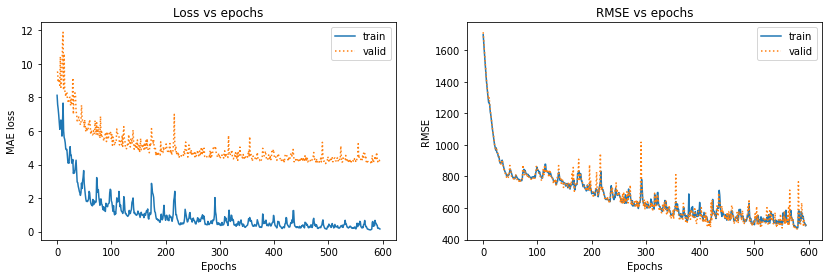

{'loss': 4.141714096069336, 'root_mean_squared_error': 490.9435729980469}


In [122]:
# Plot the learning curves

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'][10:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'][10:], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['root_mean_squared_error'][10:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_root_mean_squared_error'][10:], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Load saved model

In [123]:
from models import get_simple_mlp_concentrations
import tensorflow as tf


simple_model_load = get_simple_mlp_concentrations(input_shape=(10000,), hidden_units=[256, 256])
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.MeanSquaredError()
acc = tf.keras.metrics.RootMeanSquaredError()
simple_model_load.compile(optimizer=opt, loss=loss, metrics=[acc])
status = tf.train.Checkpoint(model=simple_model_load).restore(tf.train.latest_checkpoint('../saved_models/concentrations')).expect_partial()
status.assert_existing_objects_matched()
print(simple_model_load.evaluate(val_dataset, return_dict=True, verbose=0))

{'loss': 262095.875, 'root_mean_squared_error': 511.9529724121094}


# Performances:

## Plot the concentrations for a random exmple of the validation dataset

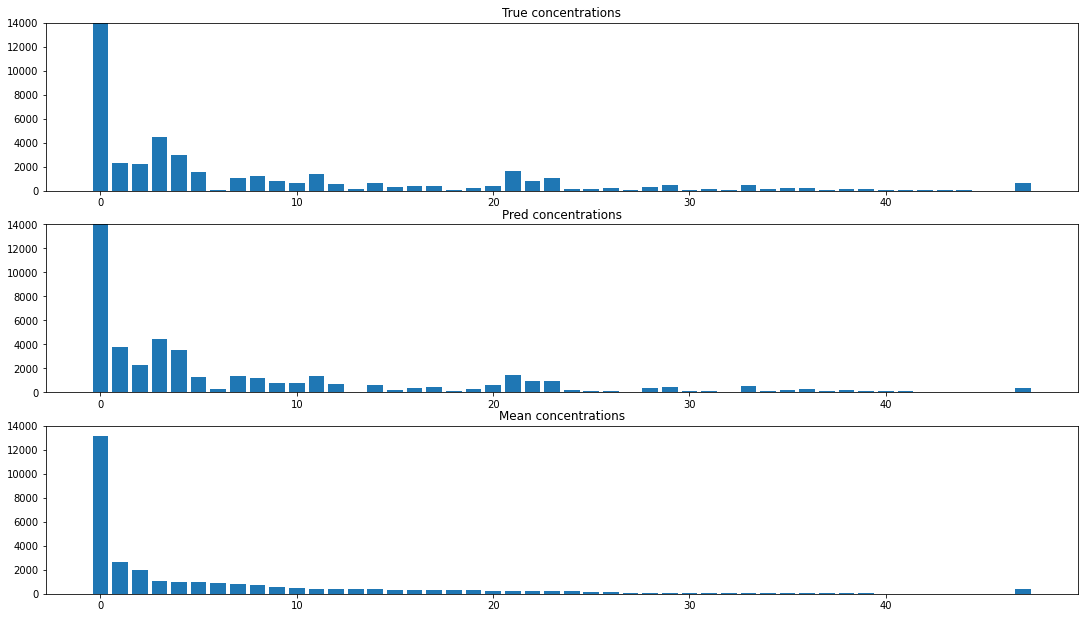

['Creatinine' 'Hippuric_acid' 'Citric_acid' 'Glycine' 'TMAO' 'Histidine'
 'phenylacetylglutamine' 'Taurine' 'glycolic_acid' 'Formate' 'Glutamine'
 'Lactate' 'lysine' 'cis-aconitic_acid' 'L_Tyrosine' 'Creatine'
 'Dimethylamine' 'guanidoacetic_acid' 'p-cresol_sulfate' 'L-alanine'
 'Arabitol' 'Isocitrate' 'Betaine' 'N-methylnicotinic_acid' 'acetate'
 'succinic_acid' 'Threonic_acid' 'Trimethylamine'
 'p-Hydroxyphenylacetic acid' 'beta-D-fructose' 'Dimethylglycine' 'NMND'
 '2-oxoglutarate' 'Galactose' 'Phenylacetate' 'L-carnosine' 'leucine'
 'Malic_acid' '2_hydroxybutyrate' 'Methionine' 'Isoleucine'
 'L-Glutamic_acid' 'citrulline' '2_deoxycytidine'
 'N-Acetyl-L-aspartic_acid' '2_deoxyadenosine' 'n-butyrate' 'L-serine']


In [124]:
import matplotlib.pyplot as plt
import numpy as np

filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)

filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

metab_number = range(48)
for parsed_record in val_dataset.shuffle(1000).take(1):
    true_concentration = parsed_record[1][0].numpy()
    pred_concentration = simple_model(parsed_record[0])[0].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)

ax1.bar(metab_number,true_concentration)
ax1.set_title("True concentrations")
ax1.set_ylim(0, 14000)

ax2.bar(metab_number, pred_concentration)
ax2.set_title("Pred concentrations")
ax2.set_ylim(0, 14000)

ax3.bar(metab_number, mean_concentrations)
ax3.set_title("Mean concentrations")
ax3.set_ylim(0, 14000)

plt.show()

print(metabolites)



# RMSE

In [125]:
print('Validation: ', simple_model.evaluate(val_dataset, return_dict=True, verbose=0))
print('Train: ', simple_model.evaluate(train_dataset, return_dict=True, verbose=0))

Validation:  {'loss': 4.141714096069336, 'root_mean_squared_error': 490.9435729980469}
Train:  {'loss': 0.12974487245082855, 'root_mean_squared_error': 488.2389221191406}


## Compute element wise RMSE

In [130]:
import pandas as pd
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
y_pred = simple_model.predict(val_dataset)
true_val = []
for batch in val_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()
element_wise_rmse = tf.math.sqrt(tf.reduce_mean(tf.math.square(y_val - y_pred), axis=0)).numpy()
element_wise_rmse = pd.Series(element_wise_rmse, index=metabolites, name='RMSE')
mean_concentrations = pd.Series(mean_concentrations, index=metabolites, name='Mean concentrations')
rule_of_thumbs = pd.Series(element_wise_rmse < mean_concentrations, index=metabolites, name='< 0.3 mean')
print(pd.concat([element_wise_rmse, mean_concentrations, rule_of_thumbs], axis=1))
print(sum(rule_of_thumbs))

                                   RMSE  Mean concentrations  < 0.3 mean
Creatinine                  2785.860278             13200.00        True
Hippuric_acid               1238.866119              2640.00        True
Citric_acid                  788.709648              2022.00        True
Glycine                      439.729335              1029.00        True
TMAO                         403.501958               982.08        True
Histidine                    617.659372               948.00        True
phenylacetylglutamine        337.278029               937.20        True
Taurine                      443.076196               834.24        True
glycolic_acid                343.829110               752.00        True
Formate                      289.122250               583.00        True
Glutamine                    191.994046               485.80        True
Lactate                      166.264228               441.00        True
lysine                       170.431233            